In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [43]:
NUM_TRADING_DAYS = 252

In [5]:
def download_data(ticker,start_date,end_date):
    ticker = yf.Ticker(ticker)
    historic_data = ticker.history(start=start_date,end=end_date)['Close']
    return historic_data

In [14]:
def visualize_dataset(dataset):
    dataset.plot(figsize=(10,5))
    plt.show()

In [33]:
#logarithmic returns are prefered for normalization of the data
def calculate_logarithmic_returns(dataset):
    log_return = np.log(dataset/dataset.shift(1))
    #first rows turn into NaN values after computation,thus returning from second row onwards.
    return log_return[1:]

In [41]:
def print_stats_for_data(dataset):
    print(f'Mean: {dataset.mean()*NUM_TRADING_DAYS}')
    print(f'Covariance: {dataset.cov()*NUM_TRADING_DAYS}')

In [48]:
#calculate the expected mean for the portfolio.with allocated wights for each constituent
def print_mean_variance_for_data(dataset,weights):
    portfolio_returns = np.sum(dataset.mean()*weights)*NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(dataset.cov()*NUM_TRADING_DAYS,weights)))
    print(f'Expected returns: {portfolio_returns}')
    print(f'Portfolio Volatility: {portfolio_volatility}')

In [19]:
start_date = '2018-01-01'
end_date = '2023-01-01'
stocks = ['TATAMOTORS.NS','SBIN.NS','ITC.NS','OFSS.NS','BHARTIARTL.NS']
stock_data = {}
for stock in stocks:
    stock_data[stock] = download_data(stock,start_date,end_date)

In [20]:
df = pd.DataFrame(stock_data)

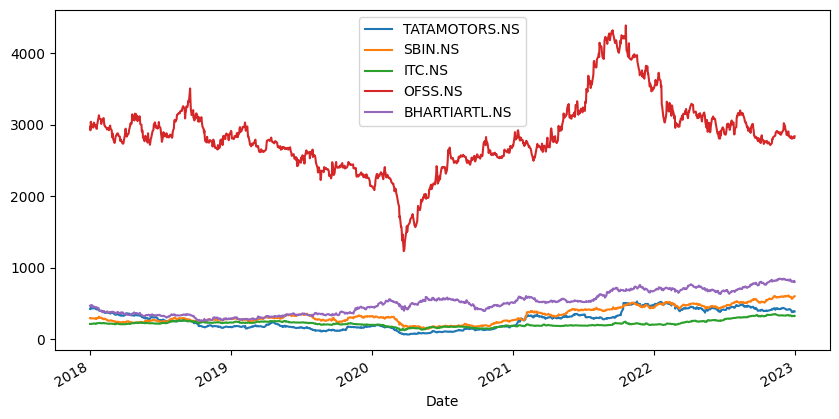

In [21]:
visualize_dataset(df)

In [38]:
log_daily_returns = calculate_logarithmic_returns(df)

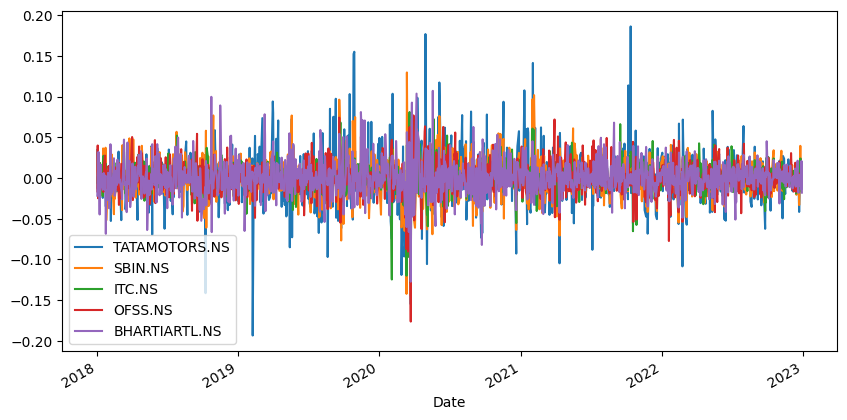

In [39]:
visualize_dataset(log_daily_returns)

In [40]:
print_stats_for_data(log_daily_returns)

Mean: TATAMOTORS.NS   -0.018348
SBIN.NS          0.146305
ITC.NS           0.085539
OFSS.NS         -0.009332
BHARTIARTL.NS    0.109681
dtype: float64
Covariance:                TATAMOTORS.NS   SBIN.NS    ITC.NS   OFSS.NS  BHARTIARTL.NS
TATAMOTORS.NS       0.240495  0.083611  0.043472  0.034010       0.049032
SBIN.NS             0.083611  0.127466  0.040216  0.027542       0.040151
ITC.NS              0.043472  0.040216  0.071315  0.017587       0.024048
OFSS.NS             0.034010  0.027542  0.017587  0.088643       0.025439
BHARTIARTL.NS       0.049032  0.040151  0.024048  0.025439       0.112647


In [50]:
print_mean_variance_for_data(log_daily_returns,np.array([0.25,0.25,0.15,0.15,0.20]))

Expected returns: 0.06535657988691707
Portfolio Volatility: 0.25519776762479823
